# Burgers Optimization with a DL-based Differentiable Physics Gradient

Use DL framework, i.e. an actual optimizer from TensorFlow

In [1]:
from phi.tf.flow import *

# run with phiflow
n = 128
steps = 32
dt = 1./steps
initial = np.zeros([n,1]) # start from 0

domain = Domain([n], boundaries=PERIODIC, box=box[-1:1])
state0 = BurgersVelocity(domain, velocity=initial, viscosity=0.01/np.pi)

# now use a real TF variable instead
state_in = state0.copied_with(velocity= variable(state0.velocity) ) # <-- main change!
states = [state_in]

for i in range(steps):
    states.append( Burgers().step(states[-1],dt=dt) )

print("Each velocity is a phiflow grid like this one: " + format(states[-1].velocity) )
#print("\nFinal vel: " + format(state[-1].velocity.data[0][0:10]) )

/home/thuerey/phiflow/phi/tf/__init__.py:7: UserWarning: TensorFlow 2 is not fully supported by PhiFlow.
  warnings.warn('TensorFlow 2 is not fully supported by PhiFlow.')


Could not load resample cuda libraries: CUDA binaries not found at /home/thuerey/phiflow/phi/tf/cuda/build/resample.so. Run "python setup.py cuda" to compile them
Instructions for updating:
Use `tf.cast` instead.


/home/thuerey/anaconda3/envs/tf/lib/python3.8/_collections_abc.py:743: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  for key in self._mapping:
/home/thuerey/anaconda3/envs/tf/lib/python3.8/_collections_abc.py:744: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  yield (key, self._mapping[key])
/home/thuerey/phiflow/phi/viz/display.py:80: UserWarning: GUI is disabled because of missing dependencies: No module named 'imageio'. To install all dependencies, run $ pip install phiflow[gui]
  warnings.warn('GUI is disabled because of missing dependencies: %s. To install all dependencies, run $ pip install phiflow[gui]' % import_error)
/home/thuerey/phiflow/phi/tf/flow.py:15: UserWarning: TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run
$ python setup.py tf_cuda
before reinstalling phiflow.
  warnings.warn("TensorFlow-CUDA solver is not available. To 

Each velocity is a phiflow grid like this one: Grid[128(1), size=[2.], <class 'numpy.float32'>]


Now we don't need to keep track and pass along `state_in`, TF knows about the initial state as a variable we'd like to optimize. This is in contrast to the previous version of this optimization, where we explicitly stored and updated a field with the intial state.

Nonetheless, this didnt run anything! We only have a graph of operations in tensorflow so far. Let's set up the loss, such that we can start the optimizer. It's actually pretty simple, we only need to compute the L2 error for the constrained state of the simulation (at $t=1/2$):

In [2]:
sess = Session(None) 

solution_t16 = np.asarray( [0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312] )
target = state0.copied_with(velocity=np.reshape(solution_t16,[n,1]))

loss = math.sum( (states[16].velocity.data - target.velocity.data)**2 ) / n

As the graph encodes the full temporal sequence, and we can compute and propagate derivatives for all intermediates, we can can now back-propagate a gradient for this loss to any earlier variable, and hence also the initial velocity state that we're interested in (and that we already declared as a `variable()` to TF above).

Note: because we're only constraining timestep 16, we could actually omit steps 17 to 31 here, but for fairness and comparison with the PINN case, let's include them.

Also, we don't need additional terms for enforcing the boundary conditions, these are already present in the simulation, and hence encoded in the execution graph for the `states` sequence above.

Now we're ready to run the optimization with one of the optimizers provided in tensorflow, e.g., the simplest starting point is always _gradient descent_ (GD):

In [3]:
LR = 5.

optim = tf.train.GradientDescentOptimizer(learning_rate=LR).minimize(loss)
#optim = tf.train.AdamOptimizer(learning_rate=0.05).minimize(loss) # overshoots?
sess.initialize_variables() # TODO dup

print('Initial loss: %f' % sess.run(loss))

import time
start = time.time()

for optim_step in range(50):
    _, loss_value = sess.run([optim, loss])
    
    if optim_step%5==0: 
        print('Step %d, loss: %f' % (optim_step,loss_value))

end = time.time()
print("Runtime {:.2f}s".format(end-start))

Initial loss: 0.382915
Step 0, loss: 0.382915
Step 5, loss: 0.194040
Step 10, loss: 0.103610
Step 15, loss: 0.059475
Step 20, loss: 0.035991
Step 25, loss: 0.022581
Step 30, loss: 0.014490
Step 35, loss: 0.009447
Step 40, loss: 0.006238
Step 45, loss: 0.004161
Runtime 0.79s


Let's visualize the reconstruction: first how well the last state of the simulation matches the target

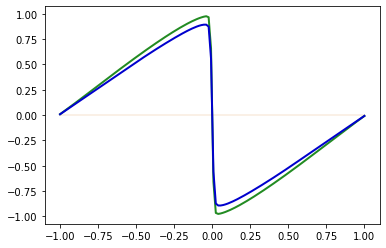

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure().gca()
pltx = np.linspace(-1,1,n)

# initial guess for optimization, this is where we started out...
fig.plot(pltx, initial.flatten()             , lw=2, color='linen')  

# target constraint at t=0.5
fig.plot(pltx, target.velocity.data.flatten(), lw=2, color='forestgreen') 

# constrained state of simulation
contrained_state = sess.run(states[16]).velocity.data
fig.plot(pltx, contrained_state.flatten(), lw=2, color='mediumblue')

Not bad. How well is the initial state recovered via backpropagation through the 16 simulation steps?
Also matches quite well:

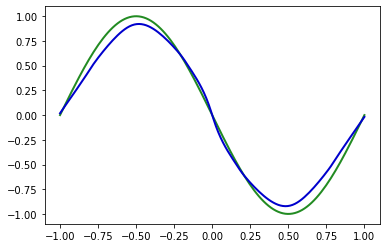

In [5]:
fig = plt.figure().gca()
pltx = np.linspace(-1,1,n)

# ground truth state at time=0 , move down
t0gt = np.asarray( [ [-math.sin(np.pi * x) * 1.] for x in np.linspace(-1,1,n)] )
fig.plot(pltx, t0gt.flatten()             , lw=2, color='forestgreen')  # ground truth initial state of sim

#fig.plot(pltx, stateN.velocity.data.flatten(), lw=2, color='mediumblue') # manual
fig.plot(pltx, sess.run(states[0]).velocity.data.flatten(), lw=2, color='mediumblue') # manual


And as MAE, and image over time...

Vels array shape: (1, 128, 33, 1)


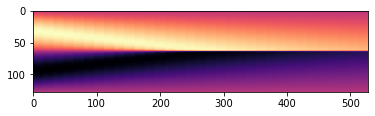

In [6]:
def show_state(a):
    # we only have 33 time steps, blow up by a factor of 2^4 to make it easier to see
    for i in range(4):
        a = np.concatenate( [a,a] , axis=3)

    a = np.reshape( a, [a.shape[1],a.shape[2]*a.shape[3]] )
    plt.imshow(a, origin='upper', cmap='magma')
    
# run all states through TF to get numpy arrays 
vels = sess.run(states) # convert all states in 1 sess.run() call
vels = [ x.velocity.data for x in vels] 
#vels = np.asarray( [ sess.run(x, feed_dict={state_in: stateN}).velocity.data for x in states] ) # also works, but slower
vels = np.concatenate(vels, axis=-1)
vels = np.reshape(vels, list(vels.shape)+[1] ) ; print("Vels array shape: "+format(vels.shape))

# TODO later?
#error = np.sum( np.abs( np.asarray(vels[0:16]).flatten() - np.asarray(velP[bc_tx:bc_tx+steps]).flatten() )) / (steps*n)
#print("Mean absolute error across {} steps: {:7.5f}".format(steps,error))

# save for comparison with other methods
np.savez_compressed("./temp/burgers-diffphys-solution.npz", np.reshape(vels,[n,steps+1])) # remove batch & channel dimension

show_state(vels)

So far only 1D Burgers, but this works with more complex model equations and higher dimensions in just the same way.

## Physics-Informed vs. Differentiable Physics Reconstruction

now we have both versions, let's compare both reconstructions in more detail...

let's first look at the solutions side by side. The code below generates an image with 3 versions, from top to bottom: the "ground truth" (GT) solution as given by the regular forward simulation, in the middle the PINN reconstruction, and at the bottom the differentiable physics version.


Solutions Ground Truth (top), PINN (middle) , DiffPhys (bottom):


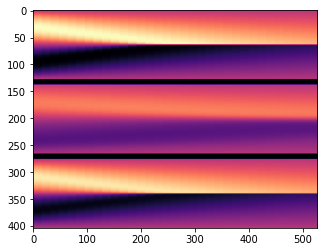

In [10]:
# note, this requires running the forward sim & PINN notebooks beforehand
sol_gt=npfile=np.load("./temp/burgers-groundtruth-solution.npz")["arr_0"] ; #print(format(sol_gt.shape)) 
sol_pi=npfile=np.load("./temp/burgers-pinn-solution.npz")["arr_0"] ; #print(format(sol_pi.shape)) 
sol_dp=npfile=np.load("./temp/burgers-diffphys-solution.npz")["arr_0"] ; #print(format(sol_dp.shape)) 

divider = np.ones([10,33])*-1. # we'll sneak in a block of -1s to show a black divider in the image
sbs = np.concatenate( [sol_gt, divider, sol_pi, divider, sol_dp], axis=0)

print("\nSolutions Ground Truth (top), PINN (middle) , DiffPhys (bottom):")
show_state(np.reshape(sbs,[1,n*3+20,33,1]))

It's clealry visible here that the PINN solution recovers the overall shape of the solution, hence the temporal constraints are at least partially fulfilled, while it doesn't manage to capture the amplitudes of the GT solution.

The reconstruction from the optimization with a differentiable solver is much closer to the ground truth thanks to an improved flow of gradients over the whole course of the sequence. In addition, it can leverage the grid-based discretization for both forwards as well as backwards passes, and in this way provide a more accurate signal to the unknown initial state. It is nonetheless visible, that the reconstruction lacks certain "sharper" features of the GT version, e.g., visible in the bottom left corner of the solution image.

Let's quantify these errors over the whole sequence:

MAE PINN: 	0.23629 
MAE DiffPhys: 	0.04718

Error GT to PINN (top) , DiffPhys (bottom):


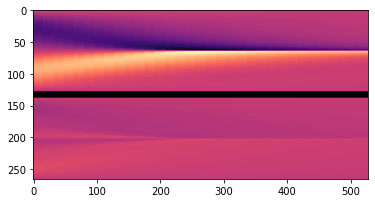

In [11]:
err_pi = np.sum( np.abs(sol_pi-sol_gt)) / (steps*n)
err_dp = np.sum( np.abs(sol_dp-sol_gt)) / (steps*n)
print("MAE PINN: \t{:7.5f} \nMAE DiffPhys: \t{:7.5f}".format(err_pi,err_dp))

print("\nError GT to PINN (top) , DiffPhys (bottom):")
show_state(np.reshape( np.concatenate([sol_pi-sol_gt, divider, sol_dp-sol_gt],axis=0) ,[1,n*2+10,33,1]))

That's pretty clear, the PINN error is ca. 5 times higher than the Differentiable Physics (DP) reconstruction.

That also shows clearly in the jointly visualized image: the magnitudes of the errors of the DP reconstruction are much closer to zero, as indicated by the purple color above.

Now we have a first example to show similarities and differences of the two approaches. In the section, we'll present a more in depth discussion of these findings, before moving to more complex cases.


---

## Next steps

As with the PINN version, there's variety of things that can be improved and experimented with here:

* You can try to adjust the training parameters to improve the reconstruction.
* As for the PINN case, you can activate a different optimizer, and observe the changing (not necessarily improved) behavior.
* Vary the number of steps, or the resolution of the simulation and reconstruction.